# Capstone Project: Shopping Coupon Recommendation - Ensemble Modeling

**Business Objective**: In this capstone project, a customer ecommerce shopping transaction data from [Kaggle](https://www.kaggle.com/code/danofer/ecommerce-store-predict-purchases-data-prep/data?select=2019-Nov.csv) is used to evaluate data and compare the performance of recommendations models that are built based on Ensemble Modeling concept. The business objective of this project is to identify the feature (like brand, product etc) that influences the user to accept or reject coupons. 

This notebook contains the recommendation basic LogisticRegression(), Boosting, Bagging, Voting and Stacking ensemble modeling analysis of the selected dataset.

In [1]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### Libraries used in this application

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import os

from matplotlib import rcParams
from scipy.linalg import svd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge, LogisticRegression, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier, BaggingClassifier, HistGradientBoostingClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import ExtraTreeClassifier, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR, SVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBClassifier
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

In [3]:
shopping = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/shopping_sample.csv')

In [4]:
shopping = shopping.drop('Unnamed: 0', axis=1)

In [5]:
shopping.drop(shopping[shopping.shopping_time == 0].index, inplace=True) #Dropping rows where shopping time == 0

In [6]:
shopping.head()

,brand,category_code,product_code,price,event_type,shopping_time,coupon
0,starline,auto,alarm,138.23,cart,10,Yes
1,samsung,electronics,smartphone,280.87,cart,16,No
2,samsung,electronics,smartphone,250.69,cart,18,No
3,polaris,appliances,iron,43.48,cart,3,Yes
4,samsung,electronics,smartphone,131.64,cart,11,Yes


In [7]:
# Checking for zero values
(shopping == 0).all()

brand            False
category_code    False
product_code     False
price            False
event_type       False
shopping_time    False
coupon           False
dtype: bool

In [8]:
shopping.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52759 entries, 0 to 53120
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   brand          52759 non-null  object 
 1   category_code  52759 non-null  object 
 2   product_code   52759 non-null  object 
 3   price          52759 non-null  float64
 4   event_type     52759 non-null  object 
 5   shopping_time  52759 non-null  int64  
 6   coupon         52759 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 3.2+ MB


#### Data Normalization

In [9]:
numeric_col = ['price', 'shopping_time']
categorical_col = ['brand', 'category_code', 'product_code' , 'event_type', 'coupon']

In [10]:
#Converting Categorical Columns to Numerical Columns using Target Encoder
shopping_encoder=shopping.copy()

encoder=preprocessing.LabelEncoder()

def target_encoder(data):
    impute_ordinal = encoder.fit_transform(np.array(data).reshape(-1,1))
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

for i in tqdm(range(len(categorical_col))):
    target_encoder(shopping_encoder[categorical_col[i]])

  0%|          | 0/5 [00:00<?, ?it/s]

In [11]:
shopping_encoder.head()

,brand,category_code,product_code,price,event_type,shopping_time,coupon
0,814,3,3,138.23,0,10,1
1,749,7,88,280.87,0,16,0
2,749,7,88,250.69,0,18,0
3,674,2,42,43.48,0,3,1
4,749,7,88,131.64,0,11,1


In [12]:
 #converting object columns to int
shopping_encoder['brand'] = shopping_encoder['brand'].astype('int')
shopping_encoder['category_code'] = shopping_encoder['category_code'].astype('int') 
shopping_encoder['product_code'] = shopping_encoder['product_code'].astype('int') 
shopping_encoder['event_type'] = shopping_encoder['event_type'].astype('int') 
shopping_encoder['coupon'] = shopping_encoder['coupon'].astype('int') 

In [13]:
# Removing outliers from the target variable 'price' using IQR
first_quartile = shopping_encoder['price'].quantile(.25)
third_quartile = shopping_encoder['price'].quantile(.75)
iqr = third_quartile - first_quartile 
lower = first_quartile - 1.5*iqr
upper = third_quartile + 1.5*iqr
shopping_no_outlier = shopping_encoder.loc[(shopping_encoder['price']>lower) & (shopping_encoder['price']<upper)]

In [14]:
shopping_encoder.describe()

,brand,category_code,product_code,price,event_type,shopping_time,coupon
count,52759.000000,52759.000000,52759.000000,52759.000000,52759.00000,52759.000000,52759.000000
mean,493.553915,5.477606,73.641710,353.036859,1.91808,11.273394,0.602286
std,319.144152,2.340687,30.209058,382.425397,0.36942,5.190675,0.489430
min,0.000000,0.000000,0.000000,0.880000,0.00000,1.000000,0.000000
25%,148.000000,3.000000,58.000000,108.030000,2.00000,7.000000,0.000000
50%,541.000000,7.000000,88.000000,221.090000,2.00000,11.000000,1.000000
75%,749.000000,7.000000,88.000000,458.135000,2.00000,16.000000,1.000000
max,958.000000,12.000000,119.000000,2574.070000,2.00000,23.000000,1.000000


In [15]:
# Using Standard Scaler to scale columns with high std
shopping_no_outlier['brand'] = StandardScaler().fit_transform(np.array(shopping_no_outlier['brand']).reshape(-1,1))
shopping_no_outlier['product_code'] = StandardScaler().fit_transform(np.array(shopping_no_outlier['product_code']).reshape(-1,1))
shopping_no_outlier['price'] = StandardScaler().fit_transform(np.array(shopping_no_outlier['price']).reshape(-1,1))

##### Feature Importance using RandomForestRegressor

In [16]:
X = shopping_no_outlier.drop(['price'], axis=1)
y = shopping_no_outlier['price']

Text(0, 0.5, 'Coeff')

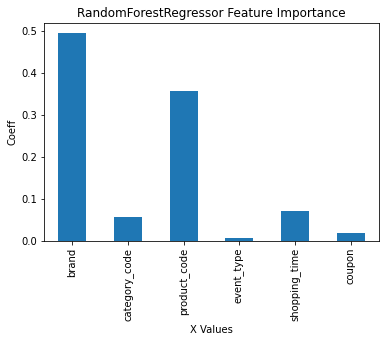

In [17]:
rf = RandomForestRegressor().fit(X, y)
rf_coeffs = pd.Series(rf.feature_importances_, index=X.columns)
rf_coeffs.plot(kind='bar')
plt.title('RandomForestRegressor Feature Importance')
plt.xlabel('X Values')
plt.ylabel('Coeff')
# Between coupon and event_type categorical features, coupon exhibits higer feature importance

In [18]:
# Saving the standardized sample dataframe as a .csv file
shopping_no_outlier.to_csv('/content/drive/MyDrive/Colab Notebooks/data/shopping_scaled.csv')

#### Data Modeling - using Ensemble Models

In [19]:
X = shopping_no_outlier.drop(['coupon'], axis=1)
y = shopping_no_outlier['coupon']

##### Logistic Regression

In [20]:
lgr = LogisticRegression(random_state=42)
lgr.fit(X, y)
lgr_preds = lgr.predict(X)

In [21]:
cross_val_score(lgr, X, y, cv=5).mean(), mean_absolute_error(y, lgr_preds), r2_score(y, lgr_preds)

(0.602782644542925, 0.39721735545707515, -0.658972780741349)

Text(0.5, 1.0, 'Confusion Matrix - Logistic Regression')

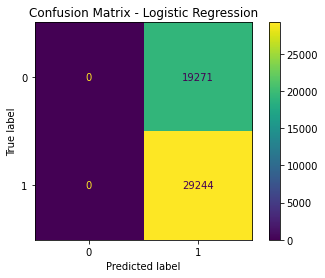

In [22]:
disp = ConfusionMatrixDisplay.from_estimator(lgr, X, y)
disp.ax_.set_title('Confusion Matrix - Logistic Regression')

In [23]:
lgr_grid = GridSearchCV(LogisticRegression(random_state=42), param_grid= {'max_iter': [10, 30, 50, 100]}, cv=5)
lgr_grid.fit(X, y)
lgr_grid_preds = lgr_grid.predict(X)

In [24]:
cross_val_score(lgr_grid, X, y, cv=5).mean(), mean_absolute_error(y, lgr_grid_preds), r2_score(y, lgr_grid_preds)

(0.6027620323611255, 0.39721735545707515, -0.658972780741349)

In [25]:
lgr_grid.best_params_

{'max_iter': 30}

In [26]:
lgr_grid.cv_results_['mean_fit_time'].mean()

0.11648617982864382

Text(0.5, 1.0, 'Confusion Matrix - Logistic Regression with GridSearchCV')

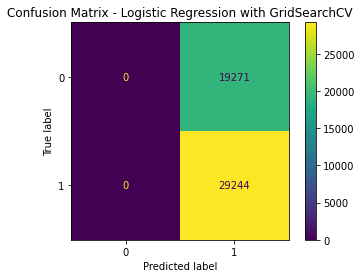

In [27]:
disp = ConfusionMatrixDisplay.from_estimator(lgr_grid, X, y)
disp.ax_.set_title('Confusion Matrix - Logistic Regression with GridSearchCV')

##### Boosting Ensemble Models

###### AdaBoostClassifier

In [28]:
ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(X, y)
ada_preds = ada.predict(X)

In [29]:
cross_val_score(ada, X, y, cv=5).mean(), mean_absolute_error(y, ada_preds), r2_score(y, ada_preds)

(0.6020612181799444, 0.3968463361846851, -0.657423223891505)

Text(0.5, 1.0, 'Confusion Matrix - AdaBoost')

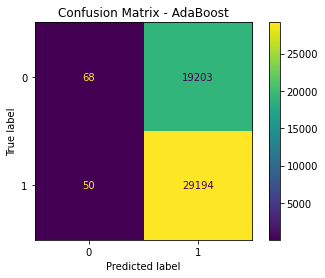

In [30]:
disp = ConfusionMatrixDisplay.from_estimator(ada, X, y)
disp.ax_.set_title('Confusion Matrix - AdaBoost')

In [31]:
ada_grid = GridSearchCV(ada, param_grid= {'n_estimators': [10, 30, 50, 100]}, cv=5)
ada_grid.fit(X, y)
ada_grid_preds = ada_grid.predict(X)

In [32]:
cross_val_score(ada_grid, X, y, cv=5).mean(), mean_absolute_error(y, ada_grid_preds), r2_score(y, ada_grid_preds)

(0.6019169329073483, 0.39721735545707515, -0.658972780741349)

In [33]:
ada_grid.best_params_

{'n_estimators': 30}

In [34]:
ada_grid.cv_results_['mean_fit_time'].mean()

0.9108983755111694

Text(0.5, 1.0, 'Confusion Matrix - AdaBoost with GridSearchCV')

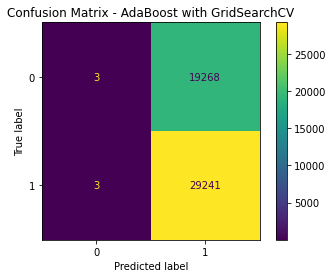

In [35]:
disp = ConfusionMatrixDisplay.from_estimator(ada_grid, X, y)
disp.ax_.set_title('Confusion Matrix - AdaBoost with GridSearchCV')

###### GradientBoostingClassifier

In [36]:
gbc = GradientBoostingClassifier(n_estimators=100, random_state=42)
gbc.fit(X, y)
gbc_preds = gbc.predict(X)

In [37]:
cross_val_score(gbc, X, y, cv=5).mean(), mean_absolute_error(y, gbc_preds), r2_score(y, gbc_preds)

(0.6016283623621559, 0.3945377718231475, -0.6477815368258086)

Text(0.5, 1.0, 'Confusion Matrix - Gradient Boosting')

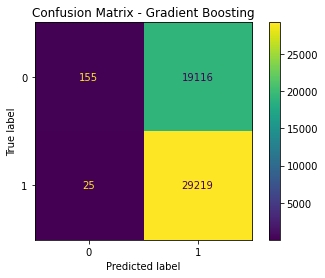

In [38]:
disp = ConfusionMatrixDisplay.from_estimator(gbc, X, y)
disp.ax_.set_title('Confusion Matrix - Gradient Boosting')

In [39]:
gbc_grid = GridSearchCV(gbc, param_grid= {'n_estimators': [10, 30, 50, 100]}, cv=5)
gbc_grid.fit(X, y)
gbc_grid_preds = gbc_grid.predict(X)

In [40]:
cross_val_score(gbc_grid, X, y, cv=5).mean(), mean_absolute_error(y, gbc_grid_preds), r2_score(y, gbc_grid_preds)

(0.6026383592703287, 0.3970524580026796, -0.658284088808085)

In [41]:
gbc_grid.best_params_

{'n_estimators': 10}

In [42]:
gbc_grid.cv_results_['mean_fit_time'].mean()

1.3348431229591369

Text(0.5, 1.0, 'Confusion Matrix - Gradient Boosting with GridSearchCV')

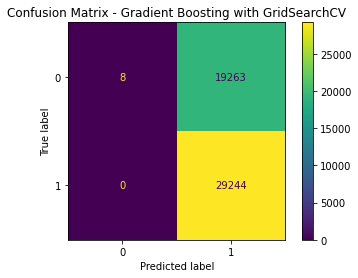

In [43]:
disp = ConfusionMatrixDisplay.from_estimator(gbc_grid, X, y)
disp.ax_.set_title('Confusion Matrix - Gradient Boosting with GridSearchCV')

###### XGBClassifier

In [44]:
xgb = XGBClassifier(n_estimators=100, random_state=42)
xgb.fit(X, y)
xgb_preds = xgb.predict(X)

In [45]:
cross_val_score(xgb, X, y, cv=5).mean(), mean_absolute_error(y, xgb_preds), r2_score(y, xgb_preds)

(0.6023291765433372, 0.3955889930949191, -0.6521719479003669)

Text(0.5, 1.0, 'Confusion Matrix - XGBClassifier')

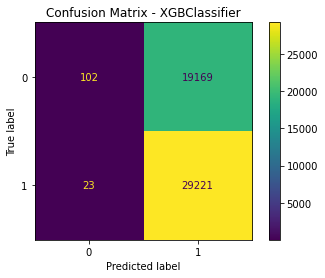

In [46]:
disp = ConfusionMatrixDisplay.from_estimator(xgb, X, y)
disp.ax_.set_title('Confusion Matrix - XGBClassifier')

In [47]:
xgb_grid = GridSearchCV(xgb, param_grid= {'n_estimators': [10, 30, 50, 100]}, cv=5)
xgb_grid.fit(X, y)
xgb_grid_preds = xgb_grid.predict(X)

In [48]:
cross_val_score(xgb_grid, X, y, cv=5).mean(), mean_absolute_error(y, xgb_grid_preds), r2_score(y, xgb_grid_preds)

(0.6023497887251364, 0.39647531691229515, -0.655873667041661)

In [49]:
xgb_grid.best_params_

{'n_estimators': 50}

In [50]:
xgb_grid.cv_results_['mean_fit_time'].mean()

0.5030197739601135

Text(0.5, 1.0, 'Confusion Matrix - XGBClassifier with GridSearchCV')

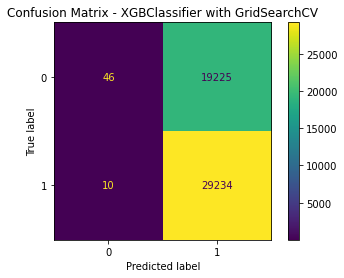

In [51]:
disp = ConfusionMatrixDisplay.from_estimator(xgb_grid, X, y)
disp.ax_.set_title('Confusion Matrix - XGBClassifier with GridSearchCV')

###### HistGradientBoostingClassifier

In [52]:
hist = HistGradientBoostingClassifier(max_iter=1000, random_state=42)
hist.fit(X, y)
hist_preds = hist.predict(X)

In [53]:
cross_val_score(hist, X, y, cv=5).mean(), mean_absolute_error(y, hist_preds), r2_score(y, hist_preds)

(0.602555910543131, 0.39653715345769347, -0.656131926516635)

Text(0.5, 1.0, 'Confusion Matrix - HistGradient Booster')

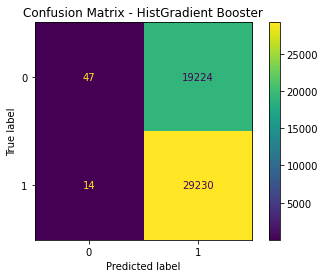

In [54]:
disp = ConfusionMatrixDisplay.from_estimator(hist, X, y)
disp.ax_.set_title('Confusion Matrix - HistGradient Booster')

In [55]:
hist_grid = GridSearchCV(hist, param_grid= {'max_iter': [10, 30, 50, 100]}, cv=5)
hist_grid.fit(X, y)
hist_grid_preds = hist_grid.predict(X)

In [56]:
cross_val_score(hist_grid, X, y, cv=5).mean(), mean_absolute_error(y, hist_grid_preds), r2_score(y, hist_grid_preds)

(0.6027620323611255, 0.39653715345769347, -0.656131926516635)

In [57]:
hist_grid.best_params_

{'max_iter': 10}

In [58]:
hist_grid.cv_results_['mean_fit_time'].mean()

0.1334307909011841

Text(0.5, 1.0, 'Confusion Matrix - HistGradient Booster with GridSearchCV')

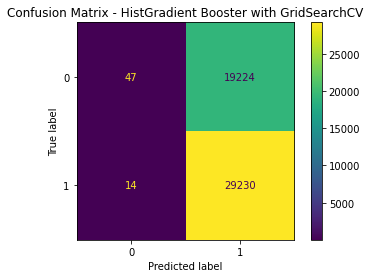

In [59]:
disp = ConfusionMatrixDisplay.from_estimator(hist_grid, X, y)
disp.ax_.set_title('Confusion Matrix - HistGradient Booster with GridSearchCV')

##### Bagging Ensemble Models

###### Bagging Ensemble - DecisionTreeClassifier as base estimator

In [60]:
dt = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42)
dt.fit(X, y)
dt_preds = dt.predict(X)

In [61]:
cross_val_score(dt, X, y, cv=5).mean(), mean_absolute_error(y, dt_preds), r2_score(y, dt_preds)

(0.533113470060806, 0.07985159229104401, 0.6665009313169018)

Text(0.5, 1.0, 'Confusion Matrix - Bagging Decision Tree')

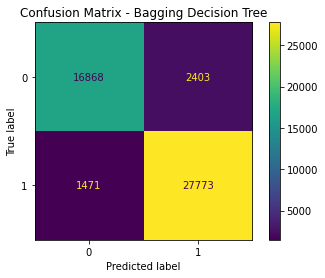

In [62]:
disp = ConfusionMatrixDisplay.from_estimator(dt, X, y)
disp.ax_.set_title('Confusion Matrix - Bagging Decision Tree')

In [63]:
dt_grid = GridSearchCV(dt, param_grid= {'n_estimators': [10, 30, 50, 100]}, cv=5)
dt_grid.fit(X, y)
dt_grid_preds = dt_grid.predict(X)

In [64]:
cross_val_score(dt_grid, X, y, cv=5).mean(), mean_absolute_error(y, dt_grid_preds), r2_score(y, dt_grid_preds)

(0.5328661238792127, 0.07985159229104401, 0.6665009313169018)

In [65]:
dt_grid.best_params_

{'n_estimators': 100}

In [66]:
dt_grid.cv_results_['mean_fit_time'].mean()

5.830844461917877

Text(0.5, 1.0, 'Confusion Matrix - Bagging Decision Tree with GridSearchCV')

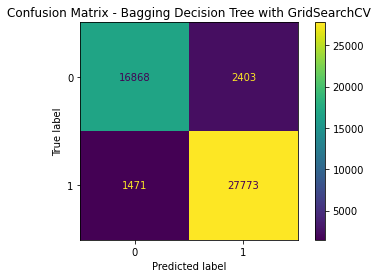

In [67]:
disp = ConfusionMatrixDisplay.from_estimator(dt_grid, X, y)
disp.ax_.set_title('Confusion Matrix - Bagging Decision Tree with GridSearchCV')

###### Bagging Ensemble - ExtraTreeClassifier as base estimator

In [68]:
et = BaggingClassifier(base_estimator=ExtraTreeClassifier(), n_estimators=100, random_state=42)
et.fit(X, y)
et_preds = et.predict(X)

In [69]:
cross_val_score(et, X, y, cv=5).mean(), mean_absolute_error(y, et_preds), r2_score(y, et_preds)

(0.5305987838812738, 0.07985159229104401, 0.6665009313169018)

Text(0.5, 1.0, 'Confusion Matrix - Bagging with ExtraTreeClassifier')

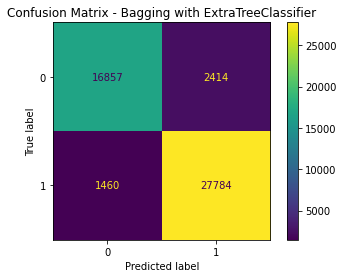

In [70]:
disp = ConfusionMatrixDisplay.from_estimator(et, X, y)
disp.ax_.set_title('Confusion Matrix - Bagging with ExtraTreeClassifier')

In [71]:
et_grid = GridSearchCV(et, param_grid= {'n_estimators': [10, 30, 50, 100]}, cv=5)
et_grid.fit(X, y)
et_grid_preds = et_grid.predict(X)

In [72]:
cross_val_score(et_grid, X, y, cv=5).mean(), mean_absolute_error(y, et_grid_preds), r2_score(y, et_grid_preds)

(0.5304132742450788, 0.07985159229104401, 0.6665009313169018)

In [73]:
et_grid.best_params_

{'n_estimators': 100}

In [74]:
et_grid.cv_results_['mean_fit_time'].mean()

1.0944211721420287

Text(0.5, 1.0, 'Confusion Matrix - Bagging with ExtraTreeClassifier with GridSearchCV')

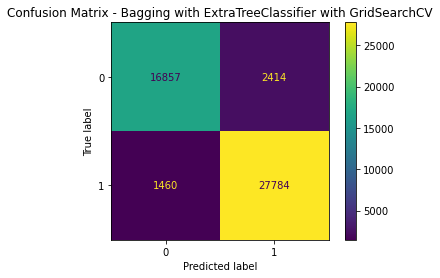

In [75]:
disp = ConfusionMatrixDisplay.from_estimator(et_grid, X, y)
disp.ax_.set_title('Confusion Matrix - Bagging with ExtraTreeClassifier with GridSearchCV')

##### Voting Ensemble Models

###### Hard Voting

In [77]:
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')
for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'Ensemble']):
  clf.fit(X, y)
  preds = clf.predict(X)
  print(label, cross_val_score(clf, X, y, cv=5).mean(), mean_absolute_error(y, preds), r2_score(y, preds))

Logistic Regression 0.602782644542925 0.39721735545707515 -0.658972780741349
Random Forest 0.5289704215191178 0.08034628465423065 0.6644348555171098
Naive Bayes 0.602782644542925 0.39721735545707515 -0.658972780741349
Ensemble 0.602782644542925 0.39721735545707515 -0.658972780741349


Text(0.5, 1.0, 'Confusion Matrix - VotingClassifier - HardVoting')

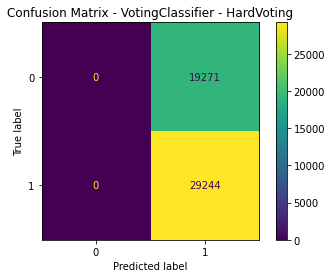

In [78]:
disp = ConfusionMatrixDisplay.from_estimator(clf, X, y)
disp.ax_.set_title('Confusion Matrix - VotingClassifier - HardVoting')

Hard Voting with GridSearch

In [80]:
params = {'lr__C': [1.0, 100.0], 'rf__n_estimators': [10, 30, 50, 100]}
grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
grid.fit(X, y)
hard_voting_preds = grid.predict(X)

In [85]:
cross_val_score(grid, X, y, cv=5).mean(), mean_absolute_error(y, hard_voting_preds), r2_score(y, hard_voting_preds)

(0.602782644542925, 0.39721735545707515, -0.658972780741349)

In [82]:
grid.best_params_

{'lr__C': 1.0, 'rf__n_estimators': 10}

In [83]:
grid.cv_results_['mean_fit_time'].mean()

2.5445349335670473

Text(0.5, 1.0, 'Confusion Matrix - VotingClassifier - HardVoting with GridSearchCV')

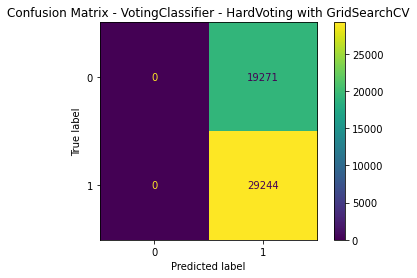

In [84]:
disp = ConfusionMatrixDisplay.from_estimator(grid, X, y)
disp.ax_.set_title('Confusion Matrix - VotingClassifier - HardVoting with GridSearchCV')

###### Soft Voting

In [86]:
clf1 = LogisticRegression(random_state=42)
clf2 = RandomForestClassifier(random_state=42)
clf3 = GaussianNB()
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft', weights=[2, 1, 2])
for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'GaussianNB', 'Ensemble']):
  clf.fit(X, y)
  preds = clf.predict(X)
  print(label, cross_val_score(clf, X, y, cv=5).mean(), mean_absolute_error(y, preds), r2_score(y, preds))

Logistic Regression 0.602782644542925 0.39721735545707515 -0.658972780741349
Random Forest 0.5310522518808616 0.07985159229104401 0.6665009313169018
GaussianNB 0.602782644542925 0.39721735545707515 -0.658972780741349
Ensemble 0.5980624549108523 0.34952076677316296 -0.4597686390447333


Text(0.5, 1.0, 'Confusion Matrix - VotingClassifier - SoftVoting')

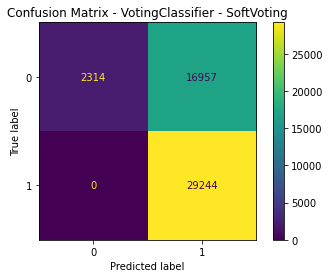

In [87]:
disp = ConfusionMatrixDisplay.from_estimator(clf, X, y)
disp.ax_.set_title('Confusion Matrix - VotingClassifier - SoftVoting')

With GridSearchSV

In [88]:
params = {'lr__C': [1.0, 100.0], 'rf__n_estimators': [20, 200]}
grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
grid.fit(X, y)
soft_voting_preds = grid.predict(X)

In [89]:
cross_val_score(grid, X, y, cv=5).mean(), mean_absolute_error(y, soft_voting_preds), r2_score(y, soft_voting_preds)

(0.5979800061836545, 0.3517262702257034, -0.46897989365213943)

In [90]:
grid.best_params_

{'lr__C': 1.0, 'rf__n_estimators': 200}

In [91]:
grid.cv_results_['mean_fit_time'].mean()

5.701870036125182

Text(0.5, 1.0, 'Confusion Matrix - VotingClassifier - SoftVoting with GridSearchCV')

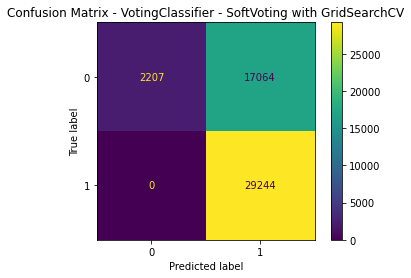

In [92]:
disp = ConfusionMatrixDisplay.from_estimator(grid, X, y)
disp.ax_.set_title('Confusion Matrix - VotingClassifier - SoftVoting with GridSearchCV')

##### Stacking Ensemble Models

In [93]:
estimators = [('rf', RandomForestClassifier(n_estimators=50, random_state=42)), ('knn', KNeighborsClassifier(n_neighbors=5)), ('gnb', GaussianNB())]
model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=42), cv=5)

clf1 = LogisticRegression(random_state=42)
clf2 = RandomForestClassifier(n_estimators=50, random_state=42)
clf3 = KNeighborsClassifier(n_neighbors=5)
clf4 = GaussianNB()
for clf, label in zip([clf1, clf2, clf3, clf4, model], ['Logistic Regression', 'Random Forest', 'KNeighbors', 'Naive Bayes', 'Ensemble']):
  clf.fit(X, y)
  preds = clf.predict(X)
  print(label, cross_val_score(clf, X, y, cv=5).mean(), mean_absolute_error(y, preds), r2_score(y, preds))

Logistic Regression 0.602782644542925 0.39721735545707515 -0.658972780741349
Random Forest 0.5290940946099145 0.0801813871998351 0.6651235474503738
KNeighbors 0.5381222302380706 0.3007523446356797 -0.25608799978190144
Naive Bayes 0.602782644542925 0.39721735545707515 -0.658972780741349
Ensemble 0.602782644542925 0.39721735545707515 -0.658972780741349


In [94]:
params = {'rf__n_estimators': [5,10]}
grid = GridSearchCV(estimator = model, param_grid=params, cv=5)
grid.fit(X, y)
grid_preds = grid.predict(X)

In [95]:
cross_val_score(grid, X, y, cv=5).mean(), mean_absolute_error(y, preds), r2_score(y, preds)

(0.602782644542925, 0.39721735545707515, -0.658972780741349)

In [96]:
grid.best_params_

{'rf__n_estimators': 5}

In [97]:
grid.cv_results_['mean_fit_time'].mean()

3.0968246459960938

Text(0.5, 1.0, 'Confusion Matrix - Stacking Classifier with GridSearchCV')

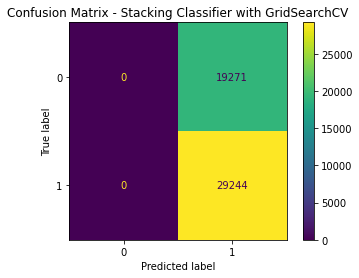

In [98]:
disp = ConfusionMatrixDisplay.from_estimator(grid, X, y)
disp.ax_.set_title('Confusion Matrix - Stacking Classifier with GridSearchCV')

##### Best Performing Model for the Sample Datset

**Conclusion:** In this capstone project, we have evaluated LogisticRegression and 9 Ensemble Models using Boosting, Bagging, Voting and Stacking Classifiers. Based on the metrics collected, tthe following models performed well,

1.   Bagging DecisionTreeClassifier WITH/WITHOUT GridSearchCV
2.   Bagging ExtraTeeClassifier WITH/WITHOUT GridSearchCV
3.   Soft VotingClassifer WITH GridSearchCV



